In [1]:
import tensorflow as tf
import math, re, os, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from kaggle_datasets import KaggleDatasets
from tensorflow import keras
from functools import partial
from sklearn.model_selection import train_test_split
import tensorflow.keras.backend as K
from sklearn.model_selection import KFold


from kaggle_datasets import KaggleDatasets
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

print("Tensorflow version " + tf.__version__)

Tensorflow version 2.2.0


In [2]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

Device: grpc://10.0.0.2:8470
Number of replicas: 8


# Set up variables
We'll set up some of our variables for our notebook here. 

If by chance you're using a private dataset, you'll also want to make sure that you have the **Google Cloud Software Development Kit (SDK)** attached to your notebook. You can find the Google Cloud SDK under the `Add-ons` dropdown menu at the top of your notebook. Documentation for the **Google Cloud Software Development Kit (SDK)** can be found **[here](https://www.kaggle.com/product-feedback/163416)**.

In [3]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
GCS_PATH = KaggleDatasets().get_gcs_path()
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
IMAGE_SIZE = [512, 512]
CLASSES = ['0', '1', '2', '3', '4']
EPOCHS = 25


SEED = 752
SKIP_VALIDATION = False
TTA_NUM = 5

random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Load the data
If you've primarily worked with notebooks in Learn, you've maybe noticed that data import and formatting is taken care of for you. But because we're working with competition data we'll have to handle this part of the pipeline ourselves.   

The data we're working with have been formatted into `TFRecords`, which are a format for storing a sequence of binary records. `TFRecords` work _really_ well with TPUs, and allow us to send a small number of large files across the TPU for processing.   

If you'd like to learn more about `TFRecords` and maybe even try creating them yourself, check out this **[TFRecords Basics notebook](https://www.kaggle.com/ryanholbrook/tfrecords-basics)** and **[corresponding video](https://youtu.be/KgjaC9VeOi8)** from Kaggle Data Scientist Ryan Holbrook.  

Because our data consists of `training` and `test` images only, we're going to split our `training` data into `training` and `validation` data using the `train_test_split()` function. 

## Decode the data
In the code chunk below we'll set up a series of functions that allow us to convert our images into tensors so that we can utilize them in our model. We'll also normalize our data. Our images are using a "Red, Blue, Green (RBG)" scale that has a range of [0, 255], and by normalizing it we'll set each pixel's value to a number in the range of [0, 1]. 

In [4]:
def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

If you think back to **[Intro to Machine Learning](https://www.kaggle.com/learn/intro-to-machine-learning)** you might remember how we set up variables like `X` and `y`, representing our `features`, `X`, and `prediction target`, `y`. This code is accomplishing something similar, although instead of using the labels `X` and `y`, our `features` are represented by the term `image` and our `prediction target` by the term `target`.  

You might also notice that this function accounts for unlabeled images. This is because our test image doesn't have any labels.  

In [5]:
def read_tfrecord(example, labeled):
    tfrecord_format = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.int64)
    } if labeled else {
        "image": tf.io.FixedLenFeature([], tf.string),
        "image_name": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    if labeled:
        label = tf.cast(example['target'], tf.int32)
        return image, label
    idnum = example['image_name']
    return image, idnum

We'll use the following function to load our dataset. One of the advantages of a TPU is that we can run multiple files across the TPU at once, and this accounts for the speed advantages of using a TPU. To capitalize on that, we want to make sure that we're using data as soon as it streams in, rather than creating a data streaming bottleneck.

In [6]:
def load_dataset(filenames, labeled=True, ordered=False):
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTOTUNE) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(partial(read_tfrecord, labeled=labeled), num_parallel_calls=AUTOTUNE)
    return dataset

## A note on using train_test_split()
While I used `train_test_split()` to create both a `training` and `validation` dataset, consider exploring **[cross validation instead](https://www.kaggle.com/dansbecker/cross-validation)**.

In [7]:
TRAINING_FILENAMES, VALID_FILENAMES = train_test_split(
    tf.io.gfile.glob(GCS_PATH + '/train_tfrecords/ld_train*.tfrec'),
    test_size=0.35, random_state=5
)

TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/test_tfrecords/ld_test*.tfrec')

## Adding in augmentations 
You learned about augmentations in the **[Computer Vision: Data Augmentation](https://www.kaggle.com/ryanholbrook/data-augmentation)** lesson on Kaggle Learn, and here I've applied an augmentation available to us through TensorFlow. You can read more about these augmentations (as well as all of the other augmentations available to you!) in the **[TensorFlow tf.image documentation](https://www.tensorflow.org/api_docs/python/tf/image)**.  

If you're interested in learning how to create and use custom augmentations, check out these **[Rotation Augmentation GPU/TPU](https://www.kaggle.com/cdeotte/rotation-augmentation-gpu-tpu-0-96)** and **[CutMix and MixUp on GPU/TPU](https://www.kaggle.com/cdeotte/cutmix-and-mixup-on-gpu-tpu)** from Kaggle Grandmaster Chris Deotte.

In [8]:
def random_blockout(img, sl=0.1, sh=0.2, rl=0.4):
    p=random.random()
    if p>=0.25:
        w, h, c = IMAGE_SIZE[0], IMAGE_SIZE[1], 3
        origin_area = tf.cast(h*w, tf.float32)

        e_size_l = tf.cast(tf.round(tf.sqrt(origin_area * sl * rl)), tf.int32)
        e_size_h = tf.cast(tf.round(tf.sqrt(origin_area * sh / rl)), tf.int32)

        e_height_h = tf.minimum(e_size_h, h)
        e_width_h = tf.minimum(e_size_h, w)

        erase_height = tf.random.uniform(shape=[], minval=e_size_l, maxval=e_height_h, dtype=tf.int32)
        erase_width = tf.random.uniform(shape=[], minval=e_size_l, maxval=e_width_h, dtype=tf.int32)

        erase_area = tf.zeros(shape=[erase_height, erase_width, c])
        erase_area = tf.cast(erase_area, tf.uint8)

        pad_h = h - erase_height
        pad_top = tf.random.uniform(shape=[], minval=0, maxval=pad_h, dtype=tf.int32)
        pad_bottom = pad_h - pad_top

        pad_w = w - erase_width
        pad_left = tf.random.uniform(shape=[], minval=0, maxval=pad_w, dtype=tf.int32)
        pad_right = pad_w - pad_left

        erase_mask = tf.pad([erase_area], [[0,0],[pad_top, pad_bottom], [pad_left, pad_right], [0,0]], constant_values=1)
        erase_mask = tf.squeeze(erase_mask, axis=0)
        erased_img = tf.multiply(tf.cast(img,tf.float32), tf.cast(erase_mask, tf.float32))

        return tf.cast(erased_img, img.dtype)
    else:
        return tf.cast(img, img.dtype)




def data_augment(image, label):
    # Thanks to the dataset.prefetch(AUTO) statement in the following function this happens essentially for free on TPU. 
    # Data pipeline code is executed on the "CPU" part of the TPU while the TPU itself is computing gradients.
    image = tf.image.random_flip_left_right(image)
    image = random_blockout(image)
    return image, label

In [9]:
def get_mat(rotation, shear, height_zoom, width_zoom, height_shift, width_shift):
    # returns 3x3 transformmatrix which transforms indicies
        
    # CONVERT DEGREES TO RADIANS
    rotation = math.pi * rotation / 180.
    shear = math.pi * shear / 180.
    
    # ROTATION MATRIX
    c1 = tf.math.cos(rotation)
    s1 = tf.math.sin(rotation)
    one = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    rotation_matrix = tf.reshape( tf.concat([c1,s1,zero, -s1,c1,zero, zero,zero,one],axis=0),[3,3] )
        
    # SHEAR MATRIX
    c2 = tf.math.cos(shear)
    s2 = tf.math.sin(shear)
    shear_matrix = tf.reshape( tf.concat([one,s2,zero, zero,c2,zero, zero,zero,one],axis=0),[3,3] )    
    
    # ZOOM MATRIX
    zoom_matrix = tf.reshape( tf.concat([one/height_zoom,zero,zero, zero,one/width_zoom,zero, zero,zero,one],axis=0),[3,3] )
    
    # SHIFT MATRIX
    shift_matrix = tf.reshape( tf.concat([one,zero,height_shift, zero,one,width_shift, zero,zero,one],axis=0),[3,3] )
    
    return K.dot(K.dot(rotation_matrix, shear_matrix), K.dot(zoom_matrix, shift_matrix))
def transform(image,label):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly rotated, sheared, zoomed, and shifted
    DIM = IMAGE_SIZE[0]
    XDIM = DIM%2 #fix for size 331
    
    rot = 15. * tf.random.normal([1],dtype='float32')
    shr = 5. * tf.random.normal([1],dtype='float32') 
    h_zoom = 1.0 + tf.random.normal([1],dtype='float32')/10.
    w_zoom = 1.0 + tf.random.normal([1],dtype='float32')/10.
    h_shift = 16. * tf.random.normal([1],dtype='float32') 
    w_shift = 16. * tf.random.normal([1],dtype='float32') 
  
    # GET TRANSFORMATION MATRIX
    m = get_mat(rot,shr,h_zoom,w_zoom,h_shift,w_shift) 

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(m,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES           
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image,tf.transpose(idx3))
        
    return tf.reshape(d,[DIM,DIM,3]),label

## Define data loading methods
The following functions will be used to load our `training`, `validation`, and `test` datasets, as well as print out the number of images in each dataset.

In [10]:
def get_training_dataset(TRAINING_FILENAMES):
    dataset = load_dataset(TRAINING_FILENAMES, labeled=True)  
    dataset = dataset.map(data_augment, num_parallel_calls=AUTOTUNE)  
    dataset = dataset.map(transform, num_parallel_calls=AUTOTUNE)
    dataset = dataset.repeat()
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

In [11]:
def get_validation_dataset(VALID_FILENAMES,ordered=False):
    dataset = load_dataset(VALID_FILENAMES, labeled=True, ordered=ordered) 
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

In [12]:
def get_test_dataset(TEST_FILENAMES,ordered=False):
    dataset = load_dataset(TEST_FILENAMES, labeled=False, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

In [13]:
def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

In [14]:
NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
NUM_VALIDATION_IMAGES = count_data_items(VALID_FILENAMES)
NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES)

print('Dataset: {} training images, {} validation images, {} (unlabeled) test images'.format(
    NUM_TRAINING_IMAGES, NUM_VALIDATION_IMAGES, NUM_TEST_IMAGES))

Dataset: 13380 training images, 8017 validation images, 1 (unlabeled) test images


# Brief exploratory data analysis (EDA)
First we'll print out the shapes and labels for a sample of each of our three datasets:

In [15]:
print("Training data shapes:")
for image, label in get_training_dataset(TRAINING_FILENAMES).take(3):
    print(image.numpy().shape, label.numpy().shape)
print("Training data label examples:", label.numpy())
print("Validation data shapes:")
for image, label in get_validation_dataset(VALID_FILENAMES).take(3):
    print(image.numpy().shape, label.numpy().shape)
print("Validation data label examples:", label.numpy())
print("Test data shapes:")
for image, idnum in get_test_dataset(TEST_FILENAMES).take(3):
    print(image.numpy().shape, idnum.numpy().shape)
print("Test data IDs:", idnum.numpy().astype('U')) # U=unicode string

Training data shapes:
(128, 512, 512, 3) (128,)
(128, 512, 512, 3) (128,)
(128, 512, 512, 3) (128,)
Training data label examples: [3 0 3 3 3 2 3 3 3 3 1 4 4 3 3 4 3 3 4 1 4 0 1 3 3 4 3 1 3 3 3 3 3 3 3 3 4
 3 3 3 1 2 3 3 1 3 3 3 3 3 3 3 3 3 2 3 3 3 1 2 3 1 3 3 0 3 3 3 3 3 2 3 3 0
 3 3 4 3 3 4 3 3 3 2 2 3 3 1 3 4 4 3 3 3 4 3 3 3 3 3 3 1 3 3 3 3 2 3 3 4 4
 4 3 0 3 3 3 3 3 2 3 3 1 2 0 2 3 3]
Validation data shapes:
(128, 512, 512, 3) (128,)
(128, 512, 512, 3) (128,)
(128, 512, 512, 3) (128,)
Validation data label examples: [3 3 3 1 3 3 3 3 4 0 4 3 0 2 4 3 3 3 3 1 3 3 2 3 3 3 1 2 3 3 1 3 0 3 3 1 3
 4 3 3 3 3 4 4 2 3 2 2 3 3 2 3 3 1 1 3 4 3 4 3 4 3 3 3 3 3 2 1 0 4 3 3 3 3
 3 0 0 2 3 3 3 2 3 3 1 3 3 3 3 3 4 3 0 3 3 2 1 3 3 3 4 4 4 3 4 3 3 3 2 4 1
 3 4 3 4 3 2 0 1 3 3 2 2 3 3 2 3 0]
Test data shapes:
(1, 512, 512, 3) (1,)
Test data IDs: ['2216849948.jpg']


The following code chunk sets up a series of functions that will print out a grid of images. The grid of images will contain images and their corresponding labels.

In [16]:
# numpy and matplotlib defaults
np.set_printoptions(threshold=15, linewidth=80)

def batch_to_numpy_images_and_labels(data):
    images, labels = data
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    if numpy_labels.dtype == object: # binary string in this case, these are image ID strings
        numpy_labels = [None for _ in enumerate(numpy_images)]
    # If no labels, only image IDs, return None for labels (this is the case for test data)
    return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
    if correct_label is None:
        return CLASSES[label], True
    correct = (label == correct_label)
    return "{} [{}{}{}]".format(CLASSES[label], 'OK' if correct else 'NO', u"\u2192" if not correct else '',
                                CLASSES[correct_label] if not correct else ''), correct

def display_one_plant(image, title, subplot, red=False, titlesize=16):
    plt.subplot(*subplot)
    plt.axis('off')
    plt.imshow(image)
    if len(title) > 0:
        plt.title(title, fontsize=int(titlesize) if not red else int(titlesize/1.2), color='red' if red else 'black', fontdict={'verticalalignment':'center'}, pad=int(titlesize/1.5))
    return (subplot[0], subplot[1], subplot[2]+1)

def display_batch_of_images(databatch, predictions=None):
    """This will work with:
    display_batch_of_images(images)
    display_batch_of_images(images, predictions)
    display_batch_of_images((images, labels))
    display_batch_of_images((images, labels), predictions)
    """
    # data
    images, labels = batch_to_numpy_images_and_labels(databatch)
    if labels is None:
        labels = [None for _ in enumerate(images)]
        
    # auto-squaring: this will drop data that does not fit into square or square-ish rectangle
    rows = int(math.sqrt(len(images)))
    cols = len(images)//rows
        
    # size and spacing
    FIGSIZE = 13.0
    SPACING = 0.1
    subplot=(rows,cols,1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE,FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))
    
    # display
    for i, (image, label) in enumerate(zip(images[:rows*cols], labels[:rows*cols])):
        title = '' if label is None else CLASSES[label]
        correct = True
        if predictions is not None:
            title, correct = title_from_label_and_target(predictions[i], label)
        dynamic_titlesize = FIGSIZE*SPACING/max(rows,cols)*40+3 # magic formula tested to work from 1x1 to 10x10 images
        subplot = display_one_plant(image, title, subplot, not correct, titlesize=dynamic_titlesize)
    
    #layout
    plt.tight_layout()
    if label is None and predictions is None:
        plt.subplots_adjust(wspace=0, hspace=0)
    else:
        plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()
    
    
def display_confusion_matrix(cmat, score, precision, recall):
    plt.figure(figsize=(15,15))
    ax = plt.gca()
    ax.matshow(cmat, cmap='Reds')
    ax.set_xticks(range(len(CLASSES)))
    ax.set_xticklabels(CLASSES, fontdict={'fontsize': 7})
    plt.setp(ax.get_xticklabels(), rotation=45, ha="left", rotation_mode="anchor")
    ax.set_yticks(range(len(CLASSES)))
    ax.set_yticklabels(CLASSES, fontdict={'fontsize': 7})
    plt.setp(ax.get_yticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    titlestring = ""
    if score is not None:
        titlestring += 'f1 = {:.3f} '.format(score)
    if precision is not None:
        titlestring += '\nprecision = {:.3f} '.format(precision)
    if recall is not None:
        titlestring += '\nrecall = {:.3f} '.format(recall)
    if len(titlestring) > 0:
        ax.text(101, 1, titlestring, fontdict={'fontsize': 18, 'horizontalalignment':'right', 'verticalalignment':'top', 'color':'#804040'})
    plt.show()
    
def display_training_curves(training, validation, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

In [17]:
# load our training dataset for EDA
training_dataset = get_training_dataset(TRAINING_FILENAMES)
training_dataset = training_dataset.unbatch().batch(20)
train_batch = iter(training_dataset)

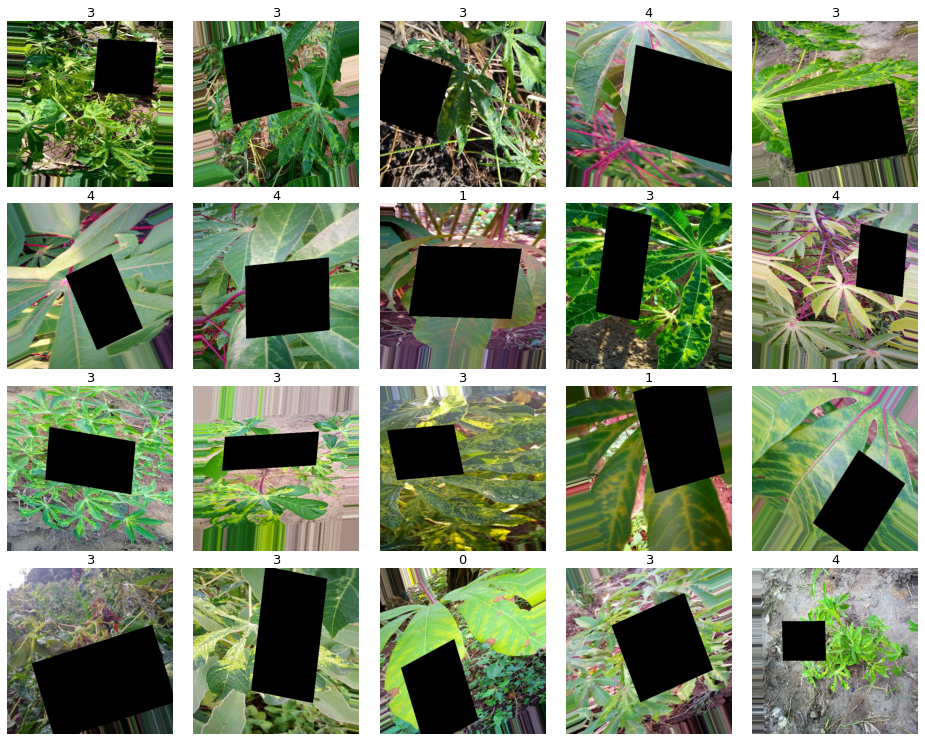

In [18]:
# run this cell again for another randomized set of training images
display_batch_of_images(next(train_batch))

In [19]:
# load our validation dataset for EDA
validation_dataset = get_validation_dataset(VALID_FILENAMES)
validation_dataset = validation_dataset.unbatch().batch(20)
valid_batch = iter(validation_dataset)

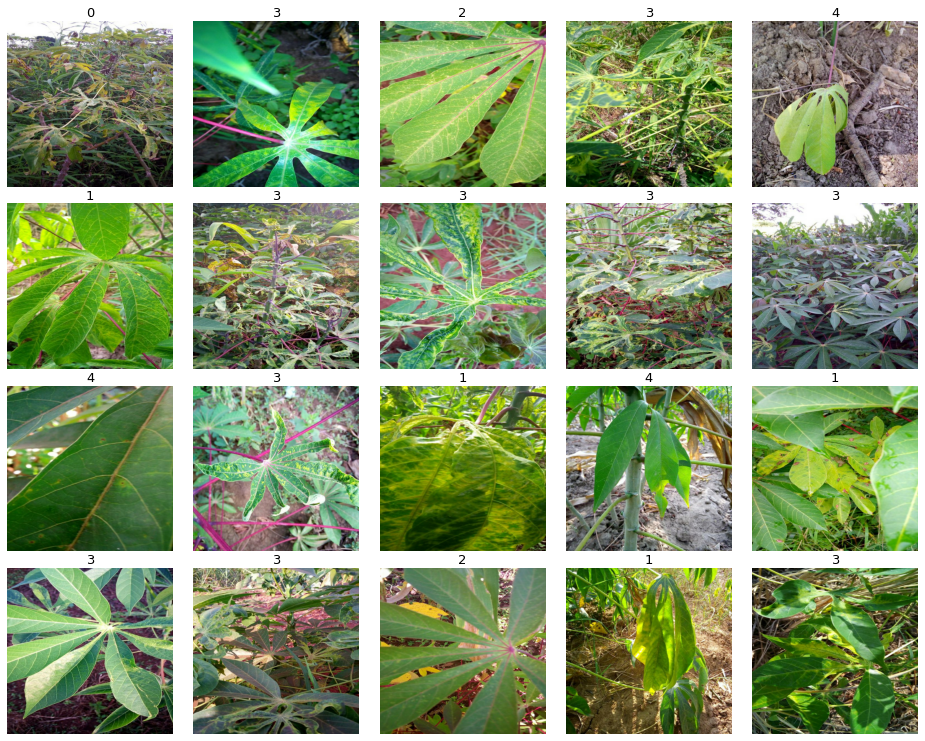

In [20]:
# run this cell again for another randomized set of training images
display_batch_of_images(next(valid_batch))

In [21]:
# load our test dataset for EDA
testing_dataset = get_test_dataset(TEST_FILENAMES)
testing_dataset = testing_dataset.unbatch().batch(20)
test_batch = iter(testing_dataset)

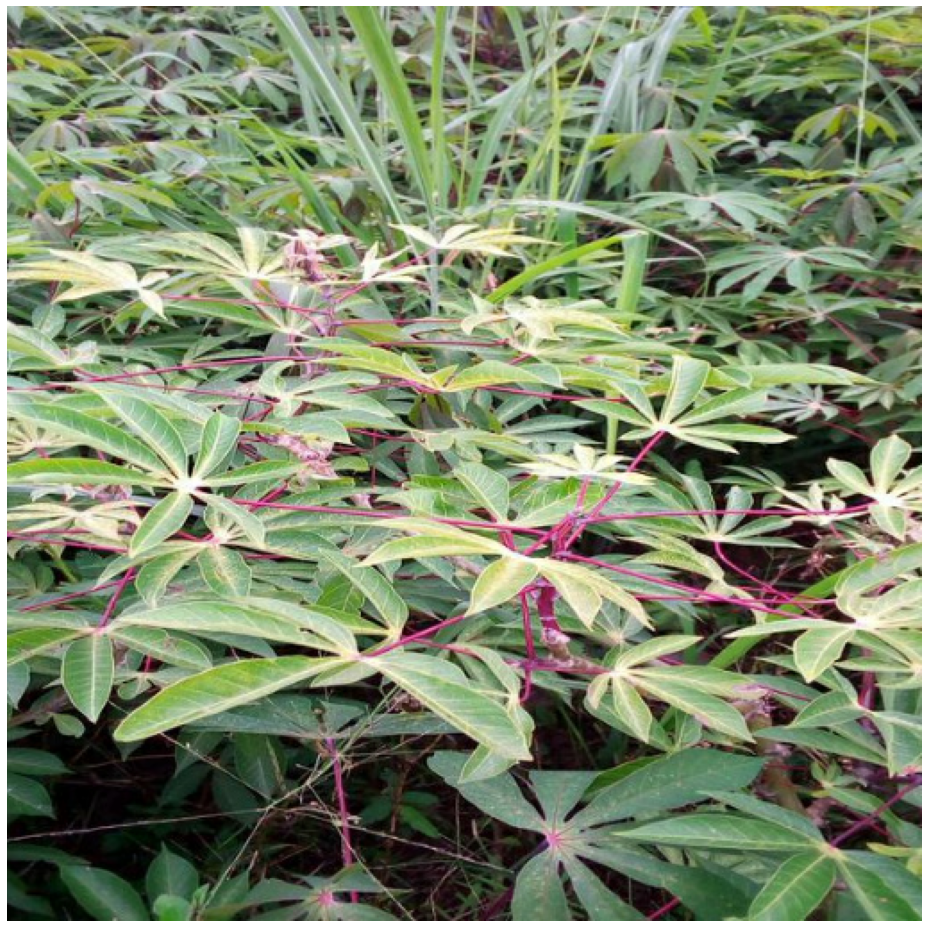

In [22]:
# we only have one test image
display_batch_of_images(next(test_batch))

Learning rate schedule: 1e-05 to 0.0004 to 1.56e-05


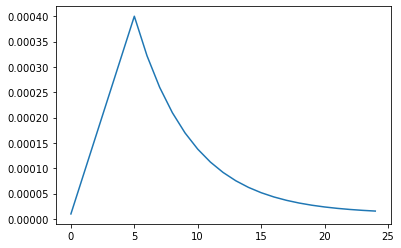

In [23]:
# Learning rate schedule for TPU, GPU and CPU.
# Using an LR ramp up because fine-tuning a pre-trained model.
# Starting with a high LR would break the pre-trained weights.



LR_START = 0.00001
LR_MAX = 0.00005 * strategy.num_replicas_in_sync
LR_MIN = 0.00001
LR_RAMPUP_EPOCHS = 5
LR_SUSTAIN_EPOCHS = 0
LR_EXP_DECAY = .8

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr


lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = True)

rng = [i for i in range(25 if EPOCHS<25 else EPOCHS)]
y = [lrfn(x) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

# Load Dataset

In [24]:
train_dataset = get_training_dataset(TRAINING_FILENAMES)
val_dataset = get_validation_dataset(VALID_FILENAMES)


# Model 

In [25]:
!pip install -U efficientnet

     |████████████████████████████████| 50 kB 1.4 MB/s 
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [26]:
import efficientnet.keras as efn 


## Efficient Net

In [27]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_sparse_categorical_accuracy', patience = 3)

In [28]:
input_shape = (*IMAGE_SIZE, 3)

with strategy.scope():
    efficient_net = efn.EfficientNetB7(weights='noisy-student', include_top=False, input_shape = input_shape)
    efficient_net.trainable = True

    model1 = tf.keras.Sequential([
        efficient_net,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(len(CLASSES), activation='softmax')
    ])
            
model1.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss = 'sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)

258072576/258068648 [==============================] - 4s 0us/step


In [29]:
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b7 (Model)      (None, 16, 16, 2560)      64097680  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2560)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 12805     
Total params: 64,110,485
Trainable params: 63,799,765
Non-trainable params: 310,720
_________________________________________________________________


In [30]:


STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE
VALID_STEPS = NUM_VALIDATION_IMAGES // BATCH_SIZE



### Training Top Layer

In [31]:
history1 = model1.fit(train_dataset, 
                        steps_per_epoch=STEPS_PER_EPOCH, 
                        epochs=EPOCHS, 
                        validation_data=val_dataset, 
                        callbacks = [lr_scheduler,early_stopping])


Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 1/25
104/104 [==============================] - 173s 2s/step - loss: 1.3414 - sparse_categorical_accuracy: 0.5605 - val_loss: 1.3975 - val_sparse_categorical_accuracy: 0.6113 - lr: 1.0000e-05

Epoch 00002: LearningRateScheduler reducing learning rate to 8.8e-05.
Epoch 2/25
104/104 [==============================] - 119s 1s/step - loss: 0.9387 - sparse_categorical_accuracy: 0.6630 - val_loss: 0.7623 - val_sparse_categorical_accuracy: 0.7411 - lr: 8.8000e-05

Epoch 00003: LearningRateScheduler reducing learning rate to 0.000166.
Epoch 3/25
104/104 [==============================] - 116s 1s/step - loss: 0.6243 - sparse_categorical_accuracy: 0.7814 - val_loss: 0.4188 - val_sparse_categorical_accuracy: 0.8549 - lr: 1.6600e-04

Epoch 00004: LearningRateScheduler reducing learning rate to 0.000244.
Epoch 4/25
104/104 [==============================] - 115s 1s/step - loss: 0.5144 - sparse_categorical_accuracy: 0.8218 - 

In [32]:
model1.save('./effcient_net.h5')

# Dense Net

In [33]:
with strategy.scope():
    densenet = tf.keras.applications.DenseNet201(input_shape=[*IMAGE_SIZE, 3], weights='imagenet', include_top=False)
    densenet.trainable = True
    
    model2 = tf.keras.Sequential([
        densenet,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(len(CLASSES), activation='softmax')
    ])
        
model2.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss = 'sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)

74842112/74836368 [==============================] - 1s 0us/step


In [34]:
history2 = model2.fit(train_dataset, 
                        steps_per_epoch=STEPS_PER_EPOCH, 
                        epochs=EPOCHS, 
                        validation_data=val_dataset, 
                        callbacks = [lr_scheduler,early_stopping])


Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 1/25
104/104 [==============================] - 124s 1s/step - loss: 1.2325 - sparse_categorical_accuracy: 0.5017 - val_loss: 0.9840 - val_sparse_categorical_accuracy: 0.6870 - lr: 1.0000e-05

Epoch 00002: LearningRateScheduler reducing learning rate to 8.8e-05.
Epoch 2/25
104/104 [==============================] - 66s 634ms/step - loss: 0.5432 - sparse_categorical_accuracy: 0.8132 - val_loss: 0.4631 - val_sparse_categorical_accuracy: 0.8524 - lr: 8.8000e-05

Epoch 00003: LearningRateScheduler reducing learning rate to 0.000166.
Epoch 3/25
104/104 [==============================] - 71s 682ms/step - loss: 0.4521 - sparse_categorical_accuracy: 0.8450 - val_loss: 0.5025 - val_sparse_categorical_accuracy: 0.8398 - lr: 1.6600e-04

Epoch 00004: LearningRateScheduler reducing learning rate to 0.000244.
Epoch 4/25
104/104 [==============================] - 69s 667ms/step - loss: 0.4326 - sparse_categorical_accuracy: 0.8

In [35]:
model2.save('./dense_net.h5')

# Evaluating our model


In [36]:

images_ds = val_dataset.map(lambda image, label: image)
labels_ds = val_dataset.map(lambda image, label: label).unbatch()

cm_correct_labels = next(iter(labels_ds.batch(NUM_VALIDATION_IMAGES))).numpy() # get everything as one batch
m1 = model1.predict(images_ds)
m2 = model2.predict(images_ds)
scores = []
for alpha in np.linspace(0,1,100):
    cm_probabilities = alpha*m1+(1-alpha)*m2
    cm_predictions = np.argmax(cm_probabilities, axis=-1)
    scores.append(f1_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro'))

best_alpha = np.argmax(scores)/100

    
print('Best alpha: ' + str(best_alpha))

Best alpha: 0.85


## Efficient net history

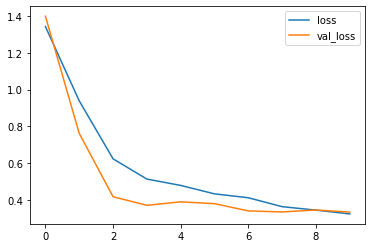

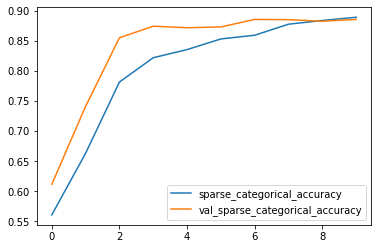

In [37]:

history_frame = pd.DataFrame(history1.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['sparse_categorical_accuracy', 'val_sparse_categorical_accuracy']].plot();

# Dense History

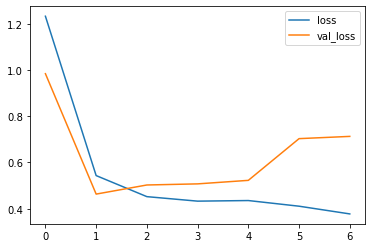

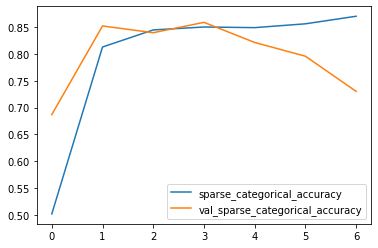

In [38]:

history_frame = pd.DataFrame(history2.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['sparse_categorical_accuracy', 'val_sparse_categorical_accuracy']].plot();

# Confusion Matrix

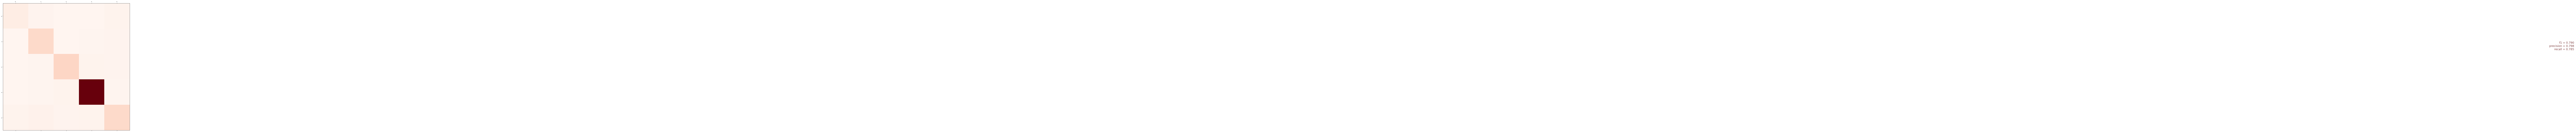

f1 score: 0.790, precision: 0.798, recall: 0.785


In [39]:
cm_probabilities = best_alpha*m1 + (1-best_alpha)*m2
cm_predictions = np.argmax(cm_probabilities, axis=-1)
cmat = confusion_matrix(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)))
score = f1_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro')
precision = precision_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro')
recall = recall_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro')
# cmat = (cmat.T / cmat.sum(axis=1)).T # normalized
display_confusion_matrix(cmat, score, precision, recall)
print('f1 score: {:.3f}, precision: {:.3f}, recall: {:.3f}'.format(score, precision, recall))

# Making predictions
Now that we've trained our model we can use it to make predictions! 

In [40]:
def predict_tta(model, n_iter):
    probs  = []
    for i in range(n_iter):
        test_ds = get_test_dataset(TEST_FILENAMES,ordered=True) # since we are splitting the dataset and iterating separately on images and ids, order matters.
        test_images_ds = test_ds.map(lambda image, idnum: image)
        probs.append(model.predict(test_images_ds,verbose=0))
        
    return probs

In [41]:
test_ds = get_test_dataset(TEST_FILENAMES) # since we are splitting the dataset and iterating separately on images and ids, order matters.


In [42]:

print('Calculating predictions...')
test_images_ds = test_ds.map(lambda image, idnum: image)
probs1 = np.mean(predict_tta(model1, TTA_NUM), axis=0)
probs2 = np.mean(predict_tta(model2, TTA_NUM), axis=0)
probabilities = best_alpha*probs1 + (1-best_alpha)*probs2
predictions = np.argmax(probabilities, axis=-1)


Calculating predictions...


In [43]:

print('Generating submission file...')
test_ids_ds = test_ds.map(lambda image, idnum: idnum).unbatch()
test_ids = next(iter(test_ids_ds.batch(NUM_TEST_IMAGES))).numpy().astype('U') # all in one batch
np.savetxt('submission.csv', np.rec.fromarrays([test_ids, predictions]), fmt=['%s', '%d'], delimiter=',', header='id,label', comments='')

Generating submission file...
